# Key Imports

$d(S_{t}/K) = \frac{1}{K}dS_{t}$

In [1]:
import numpy as np
from numpy.random import default_rng
import numba
import pandas as pd
from scipy.stats import loguniform, jarque_bera
import random

# utilities
import time
from tqdm.notebook import tqdm

# torch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import tensorboard
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter

from scipy.stats import jarque_bera
from torchviz import make_dot

# plotting
import matplotlib.pyplot as plt

plt.style.use("ggplot")
import seaborn as sns

%load_ext tensorboard

# Pricer

In [34]:
### FIXED PARAMS
r = 0
S0 = 1
T = 1
SEED = 42

### MODEL PARAMS
M = 1000  # Neural Network number of samples
MC_SAMPLES = 10000  # No. of sample paths to use for MC
N = 100  # No. of timeses to use for MC
dt = T / N

### SAMPLE PARAMS
rng = default_rng(SEED)  # fix random seed
Ks = rng.uniform(low=0.8, high=1.2, size=(M, 1))
# Ks = loguniform.rvs(a = 0.8, b = 1.2, size = (M, 1), random_state = SEED)
# Ks = np.geomspace(0.8, 1.2, M).reshape((M, 1))
lambdas = rng.uniform(low=0.5, high=1.5, size=(M, 1))
# lambdas = np.linspace(0.5, 1.5, M).reshape((M, 1))
sigmas = rng.uniform(low=0.1, high=0.5, size=(M, 1))
# sigmas = loguniform.rvs(a = 0.1, b = 0.5, size = (M, 1), random_state = SEED)
# sigmas = np.geomspace(0.1, 0.5, M).reshape((M, 1))
X = np.hstack([Ks, lambdas, sigmas])


### MC PRICES
@numba.jit(nopython=True)
def generate_MC(Sts, lam, sigma, K):
    for i in range(1, N + 1):
        Sts[:, i] = Sts[:, i - 1] * (1.0 + r * dt) + (sigma * Zs[:, i - 1]) * (
            Sts[:, i - 1] ** lam
        )
        Sts[:, i] = np.maximum(Sts[:, i], -Sts[:, i])

    return np.mean(np.exp(-r * T) * np.maximum(Sts[:, -1] - K, 0.0))


start = time.time()
Zs = rng.standard_normal(size=(MC_SAMPLES, N))
Zs = ((Zs - Zs.mean()) / Zs.std()) * np.sqrt(dt)

Sts = np.zeros((MC_SAMPLES, N + 1))
Sts[:, 0] = S0
Ps = np.zeros((M, 1))
for j in tqdm(range(M)):
    Ps[j] = generate_MC(Sts, lambdas[j], sigmas[j], Ks[j])


end = time.time()
elapsed_time = end - start

print("num nans", np.sum(np.isnan(Ps)))

  0%|          | 0/1000 [00:00<?, ?it/s]

num nans 0


## Train relationships

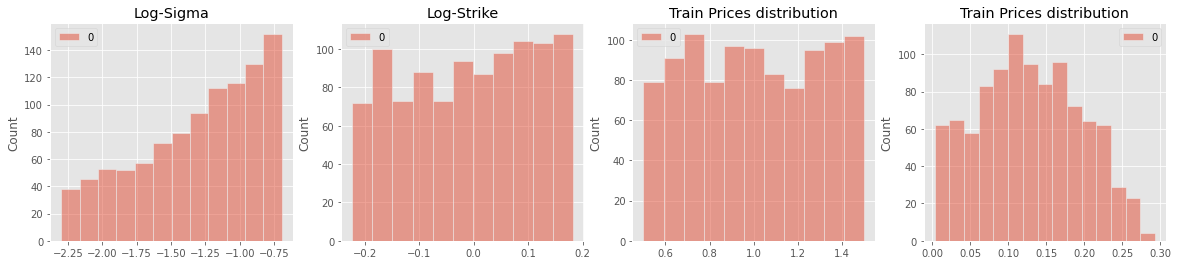

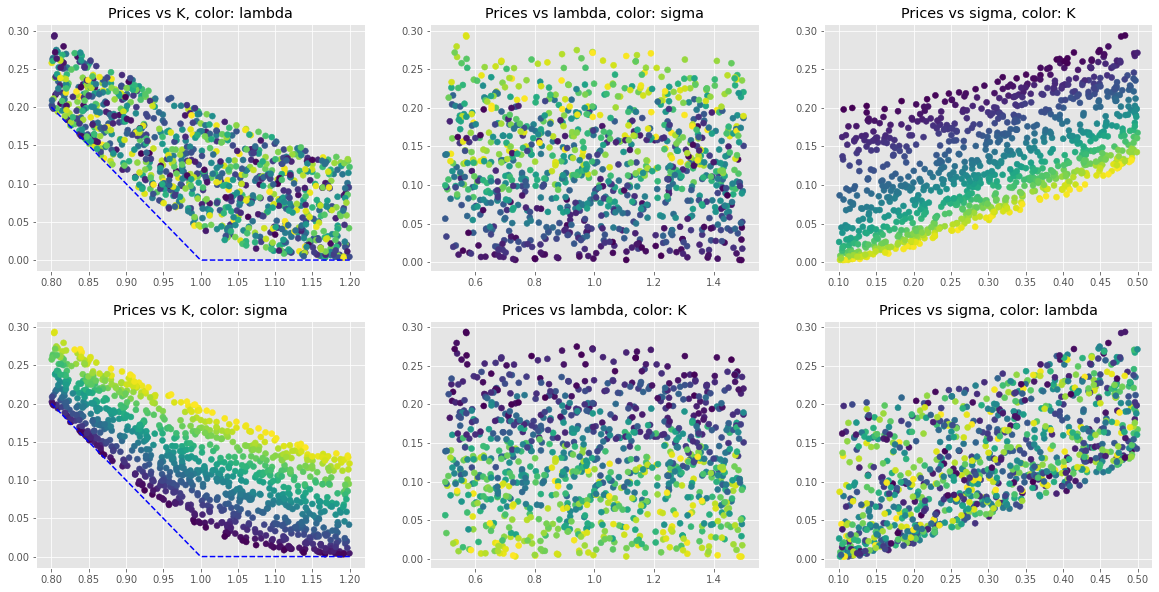

In [35]:
# Plot training distributions
fig, ax = plt.subplots(ncols=4, figsize=(20, 4))
sns.histplot(np.log(sigmas), ax=ax[0])
ax[0].set_title("Log-Sigma")
sns.histplot(np.log(Ks), ax=ax[1])
ax[1].set_title("Log-Strike")
sns.histplot(lambdas, ax=ax[2])
ax[2].set_title("Train Prices distribution")
ax[3].set_title("Train Prices distribution")
sns.histplot(Ps, ax=ax[3], label="Train Prices")

K_range = np.linspace(0.8, 1.2, 100)
lower_bound = np.maximum(S0 - np.exp(-r * T) * K_range, 0)

# Plot training relationships
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(20, 10))
feats = ["K", "lambda", "sigma"]
for i in range(6):
    ax[i // 3, i % 3].scatter(X[:, i % 3], Ps, c=X[:, [(i + (i // 3 + 1)) % 3]])
    ax[i // 3, i % 3].set_title(
        f"Prices vs {feats[i % 3]}, color: {feats[(i +  (i // 3 + 1)) % 3]}"
    )

ax[0, 0].plot(K_range, lower_bound, linestyle="--", c="blue")
ax[1, 0].plot(K_range, lower_bound, linestyle="--", c="blue")

## Define Neural Network


In [13]:
logs = []

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm1d-1                    [-1, 3]               6
            Linear-2                  [-1, 128]             512
       BatchNorm1d-3                  [-1, 128]             256
            Linear-4                  [-1, 128]          16,512
       BatchNorm1d-5                  [-1, 128]             256
            Linear-6                    [-1, 1]             129
Total params: 17,671
Trainable params: 17,671
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.07
Estimated Total Size (MB): 0.07
----------------------------------------------------------------


(torch.Size([1000, 3]), torch.Size([1000, 1]))

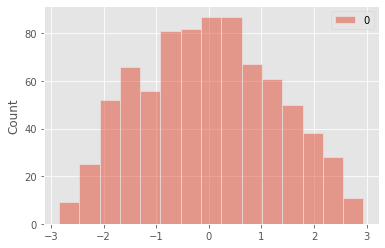

In [36]:

torch.manual_seed(SEED)
random.seed(SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"


class Net(nn.Module):
    def __init__(self, hidden_units=64):
        super(Net, self).__init__()
        # self.lower_bound = nn.Linear(3, 1)
        # self.lower_bound.weight.data = torch.tensor([[-1.0, 0, 0,]])
        # torch.nn.init.constant_(self.lower_bound.bias.data, val = 1.0)
        
        self.fc1 = nn.Linear(3, hidden_units)
        self.fc2 = nn.Linear(hidden_units, hidden_units)
        self.output = nn.Linear(hidden_units, 1)
        
        self.batch_norm1 = nn.BatchNorm1d(3)
        self.batch_norm2 = nn.BatchNorm1d(hidden_units)
        self.batch_norm3 = nn.BatchNorm1d(hidden_units)

        torch.nn.init.kaiming_normal_(self.fc1.weight, nonlinearity='linear')
        torch.nn.init.kaiming_normal_(self.fc2.weight, nonlinearity='linear')
        torch.nn.init.kaiming_normal_(self.output.weight, nonlinearity='linear')
        # torch.nn.init.uniform_(self.output.weight)

    def forward(self, x):
        # x1 = self.lower_bound(x)
        x = self.batch_norm1(x)
        x2 = F.elu(self.fc1(x))
        x2 = self.batch_norm2(x2)
        x2 = F.elu(self.fc2(x2))
        x2 = self.batch_norm3(x2)
        # x2 = F.elu(self.fc3(x2))
        return self.output(((x2)))


device = "cuda" if torch.cuda.is_available() else "cpu"
model = Net(hidden_units=128).to(device)
writer = SummaryWriter("content")
summary(model, (3,))


X2, y = torch.tensor(X, dtype=torch.float), torch.tensor(Ps, dtype=torch.float)
df = pd.DataFrame(np.hstack([X, Ps]), columns=["K", "lambda", "sigma", "P"])
# df2 = df.loc[~((1 - df['K']) > df['P'])]
df2 = df.copy()

train_size = 0.8
train_idx = int(M * train_size)

X2, y = torch.tensor(df2.iloc[:, :3].values, dtype=torch.float), torch.tensor(
    df2[["P"]].values, dtype=torch.float
)
# X2[: ,[2]] = torch.log(X2[: ,[2]])
# X2[: ,[0]] = torch.log(X2[: ,[0]])
X_train, X_test, y_train, y_test = (
    X2[:train_idx],
    X2[train_idx:],
    y[:train_idx],
    y[train_idx:],
)


sns.histplot(model(X_train).detach().numpy())
X2.shape, y.shape

In [37]:
lr = 1e-5
optimizer = optim.RMSprop(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.95)

EPOCHS = 200
losses = []
mse_losses = []
K_losses = []
vega_losses = []
violation_losses = []
test_losses = []

from tqdm.notebook import tqdm

# in your training loop:
criterion = nn.MSELoss()

for i in tqdm(range(EPOCHS)):
    optimizer.zero_grad()  # zero the gradient buffers
    X_train.requires_grad_()
    output = model(X_train)
    mse_loss = criterion(output, y_train)
    grads = torch.autograd.grad(mse_loss, X_train, retain_graph=True)[0]

    grad_K = grads[:, [0]]
    grad_K.requires_grad_()
    K_loss = 10**5 * torch.mean(F.relu(grad_K))

    sigma_loss = torch.mean((9999.0 * torch.less(grads[:, [2]], 0)))

    output.requires_grad_()
    violation_loss = torch.mean(
        1.0 * torch.greater(F.relu(1.0 - X_train[:, [0]]), output)
    )
    loss = mse_loss

    # record losses
    losses += [loss.detach().numpy()]
    print(losses[-1])
    mse_losses += [mse_loss.detach().numpy()]
    K_losses += [K_loss.detach().numpy()]
    vega_losses += [sigma_loss.detach().numpy()]
    violation_losses += [violation_loss.detach().numpy()]

    if (i - np.argmax(-np.array(losses))) > 5:
        break
    loss.backward()
    optimizer.step()  # Does the update
    with torch.no_grad():
        pass
    writer.add_scalar("Pricer-Loss/train", loss, j)

  0%|          | 0/200 [00:00<?, ?it/s]

1.5920519
0.34306487
0.11387065
0.063348316
0.049107675
0.042221297
0.037485633
0.033791933
0.030816613
0.028364198
0.026313953
0.024571257
0.023069968
0.021759264
0.020602025
0.01956983
0.018641092
0.017799037
0.017030545
0.016325157
0.015674401
0.015071439
0.014510547
0.013986993
0.013496716
0.013036387
0.012603057
0.012194207
0.011807653
0.011441492
0.011094059
0.010763846
0.010449581
0.01015007
0.009864293
0.009591316
0.009330289
0.009080462
0.0088411765
0.008611808
0.008391825
0.00818069
0.007977989
0.007783319
0.0075963396
0.0074167526
0.007244332
0.0070789065
0.0069204
0.00676884
0.0066243573
0.0064873192
0.0063582305
0.006238003
0.006127689
0.006029044
0.0059436946
0.0058742184
0.0058219456
0.0057892203
0.0057744724
0.005777469
0.005790883
0.005811632
0.005829021
0.005841094
0.005840826


{'mse': 0.005671987646328799,
 'mae': 0.11060624797366271,
 'base_mae': 0.1278996355719275,
 'base_mse': 0.06746576371756056}

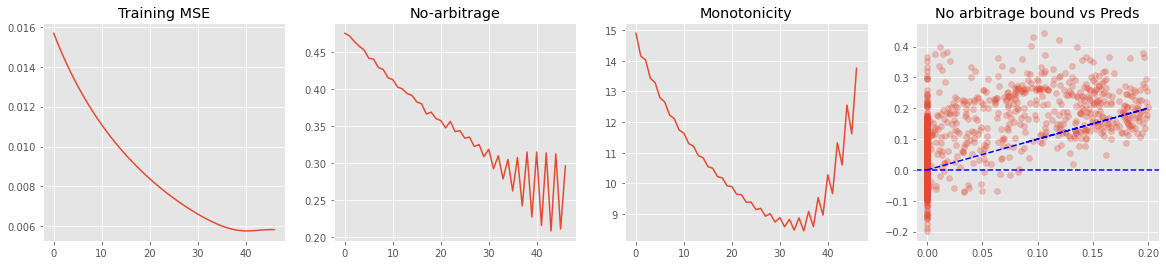

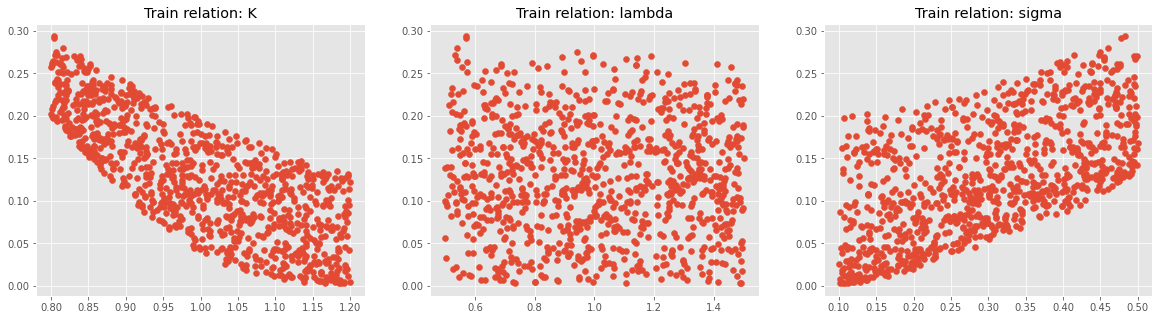

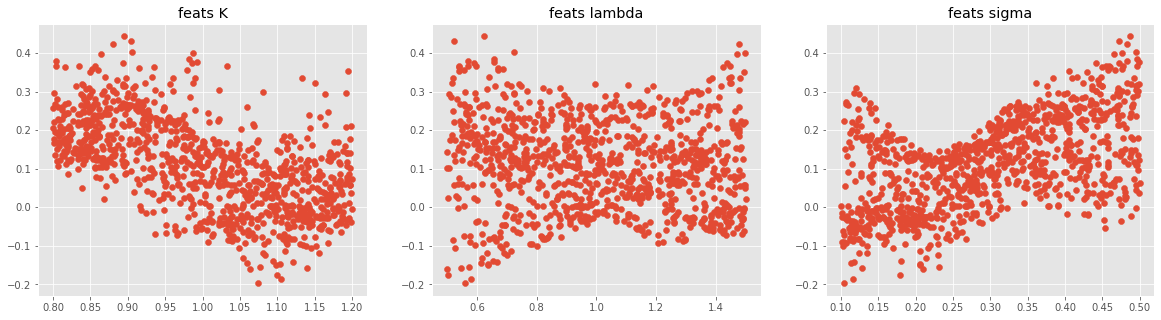

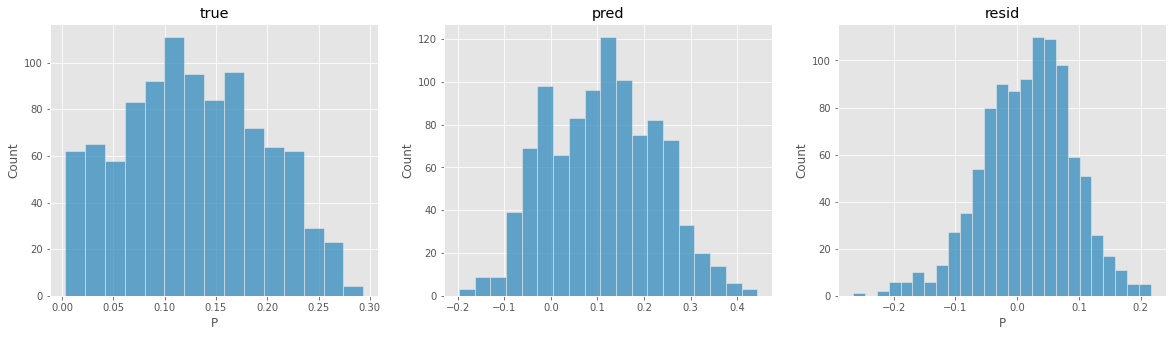

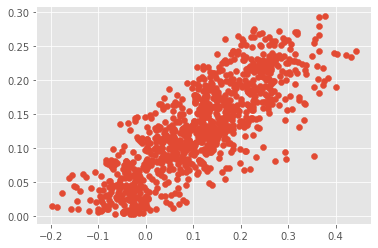

In [38]:
preds = model(X2).detach().numpy()
fig, ax = plt.subplots(ncols=4, figsize=(20, 4))
ax[0].plot(losses[20:])
ax[0].set_title("Training MSE")
# ax[1].plot(mse_losses[20:])
# ax[1].set_title("MSE")

ax[1].plot(violation_losses[20:])
ax[1].set_title("No-arbitrage")
ax[2].plot(K_losses[20:])
ax[2].set_title("Monotonicity")

ax[3].scatter(np.maximum(S0 - np.exp(-r * T) * df2["K"], 0), preds, alpha=0.3)
ax[3].plot(
    np.maximum(S0 - np.exp(-r * T) * df2["K"], 0),
    np.maximum(S0 - np.exp(-r * T) * df2["K"], 0),
    linestyle="--",
    c="blue",
)
ax[3].axhline(0, linestyle="--", c="blue")
ax[3].set_title("No arbitrage bound vs Preds")

preds = model(X2).detach().numpy().reshape(-1)


fig, ax = plt.subplots(ncols=3, figsize=(20, 5))
feats = ["K", "lambda", "sigma"]
for i in range(3):
    ax[i].scatter(X[:, i], Ps)
    ax[i].set_title(f"Train relation: {feats[i]}")

fig, ax = plt.subplots(ncols=3, figsize=(20, 5))
feats = ["K", "lambda", "sigma"]
for i in range(3):
    ax[i].scatter(df2.iloc[:, i], preds)
    ax[i].set_title(f"feats {feats[i]}")

fig, ax = plt.subplots(ncols=3, figsize=(20, 5))
sns.histplot(df2["P"] - preds, ax=ax[2])
sns.histplot(preds, ax=ax[1])
sns.histplot(df2["P"], ax=ax[0])

for i, x in enumerate(["true", "pred", "resid"]):
    ax[i].set_title(x)

logs += [
    {
        "mse": np.mean((preds - df2["P"]) ** 2),
        "mae": np.mean(np.abs(preds - Ps)),
        "base_mae": np.abs(df2["P"]).mean(),
        "base_mse": np.std(df2["P"]),
    }
]
fig, ax = plt.subplots()

ax.scatter(preds, df2["P"])

logs[-1]

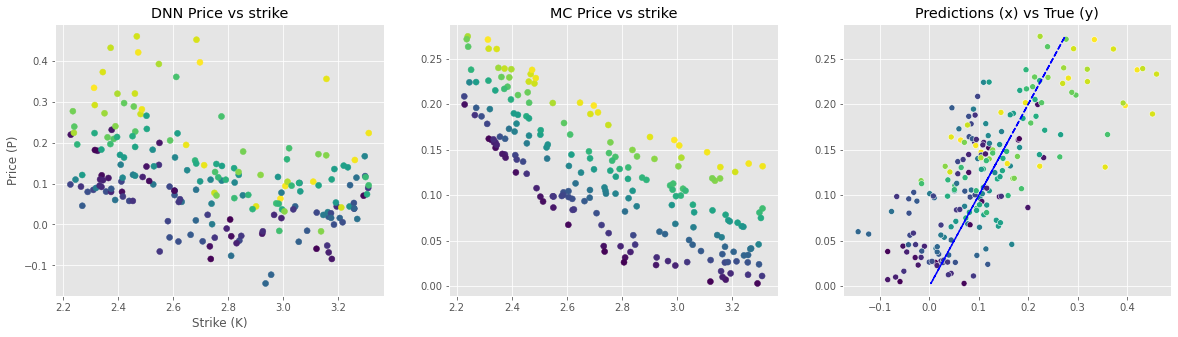

In [39]:
preds_test = model(X_test).detach().numpy().reshape(-1)
fig, ax = plt.subplots(ncols=3, figsize=(20, 5))
ax[0].scatter(np.exp(X_test[:, 0].detach().numpy()), preds_test, c=X_test[:, 2] * 0.5)
ax[0].set_title("DNN Price vs strike")
ax[0].set_xlabel("Strike (K)")
ax[0].set_ylabel("Price (P)")
ax[1].scatter(np.exp(X_test[:, 0].detach().numpy()), y_test, c=X_test[:, 2] * 0.5)
ax[1].set_title("MC Price vs strike")

sns.scatterplot(x=preds_test, y=y_test.reshape(-1), ax=ax[2], c=X_test[:, 2])

ax[2].plot(y_test.reshape(-1), y_test.reshape(-1), linestyle="--", color="blue")
ax[2].set_title("Predictions (x) vs True (y)");

In [31]:
# train predictions
print("TRAIN")
y2 = y.detach().numpy().reshape(-1)
preds = model(X2).detach().numpy().reshape(-1)
for x in [
    np.mean(np.abs(preds - y2)),  # mae
    np.max(np.abs(preds - y2)),  # max-norm
    np.sqrt(np.mean((preds - y2) ** 2)),  # rmse
    np.mean(np.abs((y2 - preds) / y2)),
]:  # mape
    print(f"{x:.6f}")

print("TEST")
# test predictions
y_test_np = y_test.detach().numpy().reshape(-1)
for x in [
    np.mean(np.abs(preds_test - y_test_np)),  # mae
    np.max(np.abs(preds_test - y_test_np)),  # max-norm
    np.sqrt(np.mean((preds_test - y_test_np) ** 2)),  # rmse
    np.mean(np.abs((y_test_np - preds_test) / y_test_np)),
]:  # mape
    print(f"{x:.6f}")

TRAIN
0.053931
0.208921
0.066558
inf
TEST
0.053203
0.197515
0.065643
inf


/var/folders/gg/bdgg0c0n28x14l2hd83rbx3c0000gn/T/ipykernel_21361/3673505699.py:9: RuntimeWarning: divide by zero encountered in true_divide
  np.mean(np.abs((y2 - preds) / y2)),
/var/folders/gg/bdgg0c0n28x14l2hd83rbx3c0000gn/T/ipykernel_21361/3673505699.py:20: RuntimeWarning: divide by zero encountered in true_divide
  np.mean(np.abs((y_test_np - preds_test) / y_test_np)),


## Question 2c)d) - Out of sample Test Set

In [32]:
n_K = 1000
K_eval = np.linspace(0.8, 1.2, n_K)

X_eval = torch.tensor(
    np.vstack([np.log(K_eval), 1.5 * np.ones(n_K), np.log(0.5 * np.ones(n_K))]).T,
    dtype=torch.float,
)

### Generate MC samples
Ps_eval = np.zeros((n_K, 1))

start = time.time()
Ps_eval = np.array([generate_MC(Sts, 1.5, 0.5, K_eval[i]) for i in tqdm(range(n_K))])
MC_time = time.time() - start

start = time.time()
preds = model(X_eval).detach().numpy().reshape(-1)
model_time = time.time() - start
print(MC_time, model_time)

print("OOS")
for x in [
    np.mean(np.abs(preds - Ps_eval)),  # mae
    np.max(np.abs(preds - Ps_eval)),  # max-norm
    np.sqrt(np.mean((preds - Ps_eval) ** 2)),  # rmse
    np.mean(np.abs((Ps_eval - preds) / Ps_eval)),
]:  # mape
    print(f"{x:.6f}")

  0%|          | 0/1000 [00:00<?, ?it/s]

0.11678266525268555 0.021816015243530273
OOS
1.062806
2.299750
1.187357
3.422478


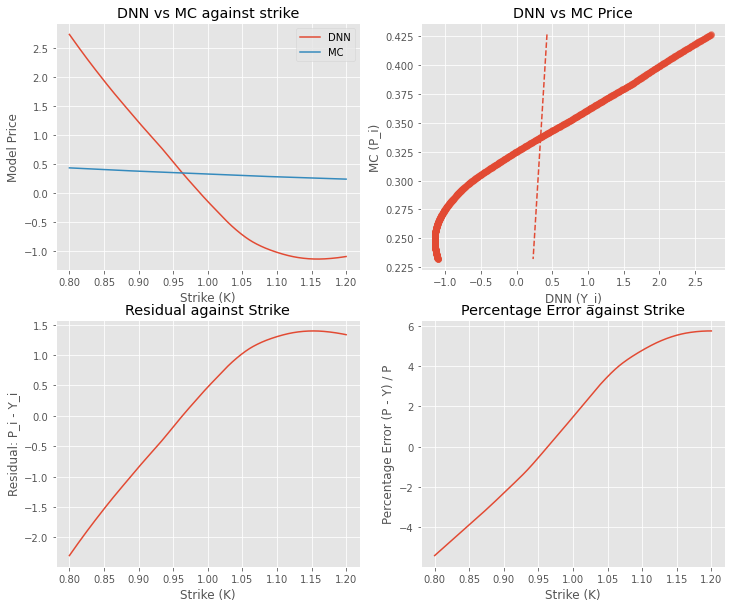

In [33]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(12, 10))
ax[0, 0].plot(K_eval, preds, label="DNN")
ax[0, 0].plot(K_eval, Ps_eval, label="MC")
ax[0, 0].set_xlabel("Strike (K)")
ax[0, 0].set_ylabel("Model Price")
ax[0, 0].legend()
ax[0, 0].set_title("DNN vs MC against strike")
ax[1, 0].plot(K_eval, Ps_eval - preds)
ax[1, 0].set_xlabel("Strike (K)")
ax[1, 0].set_ylabel("Residual: P_i - Y_i")
ax[1, 0].set_title("Residual against Strike")
ax[0, 1].scatter(preds, Ps_eval, alpha=0.5)
ax[0, 1].plot(Ps_eval, Ps_eval, linestyle="--")
ax[0, 1].set_xlabel("DNN (Y_i)")
ax[0, 1].set_ylabel("MC (P_i)")
ax[0, 1].set_title("DNN vs MC Price")

ax[1, 1].plot(K_eval, (Ps_eval - preds) / Ps_eval)
ax[1, 1].set_xlabel("Strike (K)")
ax[1, 1].set_ylabel("Percentage Error (P - Y) / P")
ax[1, 1].set_title("Percentage Error against Strike");

# DNN Local Vol / Neural SDE  - Question 2e)2f) 

## Generate Prices

In [225]:
### FIXED PARAMS
r = 0
S0 = 1
T = 1
SEED = 42

### MODEL PARAMS
M = 20  # Neural Network number of samples
MC_SAMPLES = 5000  # No. of sample paths to use for MC
N = 50  # No. of timeses to use for MC
dt = T / N

### SAMPLE PARAMS
rng = default_rng(SEED)  # fix random seed
Ks = rng.uniform(low=0.8, high=1.2, size=(M, 1))

### MC PRICES
@numba.jit(nopython=True)
def generate_MC(Sts, lam, sigma, K):
    for i in range(1, N + 1):
        Sts[:, i] = Sts[:, i - 1] * (1.0 + r * dt) + (sigma * Zs[:, i - 1]) * (
            Sts[:, i - 1] ** lam
        )
        Sts[:, i] = np.maximum(Sts[:, i], -Sts[:, i])

    return np.mean(np.exp(-r * T) * np.maximum(Sts[:, -1] - K, 0.0))


start = time.time()
Zs = rng.standard_normal(size=(MC_SAMPLES, N))
Zs = ((Zs - Zs.mean()) / Zs.std()) * np.sqrt(dt)

Sts = np.zeros((MC_SAMPLES, N + 1))
Sts[:, 0] = S0
Ps = np.zeros((M, 1))
for j in tqdm(range(M)):
    Ps[j] = generate_MC(Sts, lam=1.5, sigma=0.5, K=Ks[j])


end = time.time()
elapsed_time = end - start
print(elapsed_time)

### Convert to torch tensors
Ks = torch.tensor(Ks)
Ws = torch.tensor(Zs)
Ps = torch.tensor(Ps)
Ps = Ps.reshape(M)
Ks = torch.transpose(Ks, 1, 0)

print(Ks.shape, Ps.shape, Ws.shape)

  0%|          | 0/20 [00:00<?, ?it/s]

3.491818904876709
torch.Size([1, 20]) torch.Size([20]) torch.Size([5000, 50])


## Define Neural Network

In [ ]:
torch.manual_seed(2022)
random.seed(0)


class SDENet(nn.Module):
    def __init__(self, hidden_units=512):
        super(SDENet, self).__init__()
        # self.lower_bound = nn.Linear(3, 1)
        # self.lower_bound.weight.data = torch.tensor([[-1.0, 0, 0,]])
        # torch.nn.init.constant_(self.lower_bound.bias.data, val = 1.0)
        self.fc1 = nn.Linear(1, 512)
        torch.nn.init.kaiming_normal_(self.fc1.weight)
        self.fc2 = nn.Linear(512, 1)
        torch.nn.init.kaiming_normal_(self.fc2.weight)
        self.output = nn.Linear(1, 1)

    def forward(self, x):
        x = torch.log(x)
        x2 = F.elu(self.fc1(x))
        x2 = torch.exp(F.elu(self.fc2((x2))))
        return self.output(x2)


device = "cuda" if torch.cuda.is_available() else "cpu"
model = SDENet(hidden_units=500).to(device)
writer = SummaryWriter("/content/logsdir")
summary(model, (1,))

# fig = make_dot(model(torch.ones((10, 1))).mean(), params=dict(model.named_parameters()))
# fig.render("graph.png", view=True, format='png')
# fig

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]           1,024
            Linear-2                    [-1, 1]             513
            Linear-3                    [-1, 1]               2
Total params: 1,539
Trainable params: 1,539
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.01
----------------------------------------------------------------


In [ ]:
lr = 1e-3
optimizer = optim.RMSprop(model.parameters(), lr=lr)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer)

EPOCHS = 100
losses = []

criterion = nn.MSELoss()
for j in tqdm(range(EPOCHS)):
    optimizer.zero_grad()
    Y0 = torch.ones((MC_SAMPLES, 1))
    for t in range(N):
        # Y0[:, [t + 1]] += r * Y0[:, [t]] * dt + model(Y0[:, [t]]) * Ws[:, [t]]
        Y0 = Y0 + Y0 * (r * dt) + model(Y0.float()) * Ws[:, [t]]
        Y0 = F.relu(Y0) + F.relu(-Y0)
    loss = criterion(torch.mean(F.relu((Y0 * torch.ones(1, 20) - Ks)), 0), Ps)

    loss.backward()
    losses += [loss.detach().numpy()]
    print(losses[-1])
    optimizer.step()
    scheduler.step(loss)
    writer.add_scalar("Loss/train", loss, j)

  0%|          | 0/100 [00:00<?, ?it/s]

0.008354151230659392
0.0011132833483216437
0.001009155155704934
0.0009242385097910309
0.0008525863572653523
0.0007909140875583343
0.0007371527435533368
0.0006897905923603031
0.0006478290575258086
0.0006106125647558148
0.0005772981031925552
0.0005473401173758415
0.0005203147765629691
0.0004958690836932948
0.0004736492894155512
0.0004534501613672361
0.00043506619639324727
0.000418327454258241
0.0004030723540097681
0.0003891454406591141
0.0003764513652922504
0.000364857893813919
0.00035424870211255217
0.00034453860499124593
0.00033564352878669
0.0003274906274678905
0.0003200142613182731
0.0003131579947315198
0.0003068688281232827
0.00030109881767715013
0.0002958047267518924
0.0002909457470708435
0.0002864855994013104
0.0002823919668643162
0.00027863138241548144
0.00027518293134449806
0.0002720181810604577
0.0002691143896804979
0.00026645079477784597
0.00026400726929595643
0.00026176561674782757
0.00025970949005555755
0.0002578241647490948
0.00025609605287995127
0.00025451188787647586
0.00

(50.26425448018715, 1.2169043550613878e-11)


Text(0.5, 1.0, 'Y_T distribution')

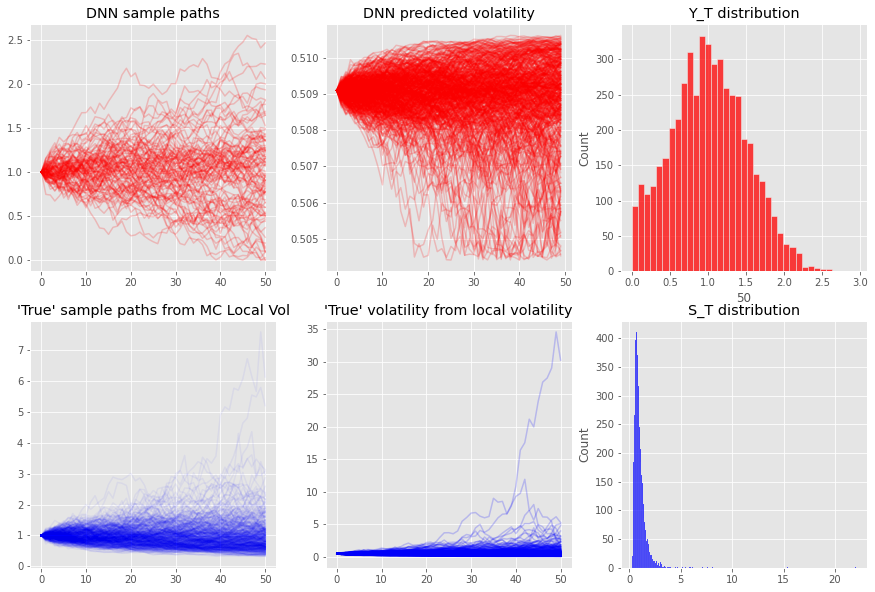

In [ ]:
# compute NN SDE paths
with torch.no_grad():
    Y0 = torch.ones((MC_SAMPLES, N + 1), dtype=torch.float)
    vols = torch.ones((MC_SAMPLES, N))
    temp = torch.ones((MC_SAMPLES, 1))
    for t in range(N):
        Y0[:, [t + 1]] = (
            Y0[:, [t]] + r * Y0[:, [t]] * dt + model(Y0[:, [t]].float()) * Ws[:, [t]]
        ).float()
        Y0[:, [t + 1]] = F.relu(Y0[:, [t + 1]]) + F.relu(-Y0[:, [t + 1]])
    for t in range(N):
        vols[:, [t]] = model(Y0[:, [t]].float())

fig, ax = plt.subplots(ncols=3, figsize=(15, 10), nrows=2)

### Plot sample paths
Ys = pd.DataFrame(Y0.detach().numpy())
Ys.sample(100).T.plot(alpha=0.2, c="red", ax=ax[0, 0])
ax[0, 0].get_legend().remove()
ax[0, 0].set_title("DNN sample paths")


Sts_df = pd.DataFrame(Sts)
Sts_df.sample(500).T.plot(ax=ax[1, 0], c="blue", alpha=0.05)
ax[1, 0].get_legend().remove()
ax[1, 0].set_title("'True' sample paths from MC Local Vol")

### Plot sample volatility
vols_df = pd.DataFrame(vols.detach().numpy())
vols_df.sample(500).T.plot(alpha=0.2, c="red", ax=ax[0, 1])
ax[0, 1].get_legend().remove()
ax[0, 1].set_title("DNN predicted volatility")

(0.5 * (Sts_df.sample(500) ** 1.5)).T.plot(alpha=0.2, c="blue", ax=ax[1, 1])
ax[1, 1].get_legend().remove()
ax[1, 1].set_title("'True' volatility from local volatility")

### Plot terminal distributions
print(jarque_bera(Ys.iloc[:, -1]))

sns.histplot(Sts[:, -1], color="blue", ax=ax[1, 2])
ax[1, 2].set_title("S_T distribution")
sns.histplot(Ys.iloc[:, -1], color="red", ax=ax[0, 2])
ax[0, 2].set_title("Y_T distribution")

0.00023662071442064848
0.00023657214211350282 0.04098691922050654


Text(0, 0.5, 'Residual')

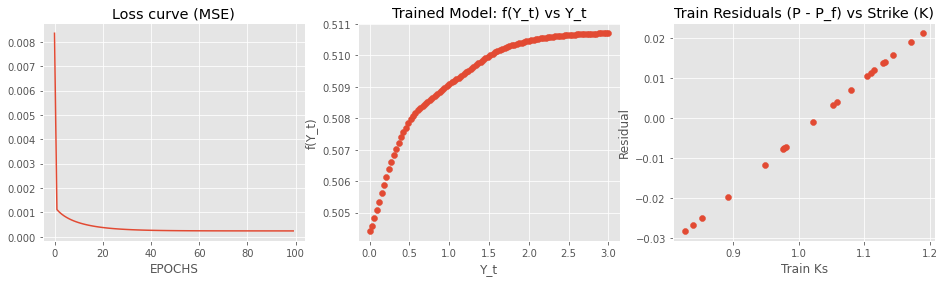

In [ ]:
fig, ax = plt.subplots(figsize=(16, 4), ncols=3)
ax[0].plot(losses)
### Loss curve
ax[0].set_title("Loss curve (MSE)")
ax[0].set_xlabel("EPOCHS")
print(np.min(losses))
### f(Y_t) vs Y_t
with torch.no_grad():
    X_test = torch.linspace(1e-5, 3, 100).reshape((-1, 1))
    ax[1].scatter(X_test, model(X_test))

    resid = (
        torch.mean(
            F.relu((torch.tensor(Ys.iloc[:, [-1]].values) * torch.ones(1, 20) - Ks)), 0
        )
        - Ps
    )
    print(np.mean((resid.detach().numpy()) ** 2), Ps.std().detach().numpy())
    ax[2].scatter(Ks.detach().numpy().reshape(-1), -resid)

### Train Residuals vs Strike
ax[1].set_title("Trained Model: f(Y_t) vs Y_t")
ax[1].set_xlabel(f"Y_t")
ax[1].set_ylabel(f"f(Y_t)")
ax[2].set_title(f"Train Residuals (P - P_f) vs Strike (K)")
ax[2].set_xlabel(f"Train Ks")
ax[2].set_ylabel(f"Residual");

## Out-Of-Sample MC Price Generation

In [ ]:
SEED = 2022
### SAMPLE PARAMS
rng = default_rng(SEED)  # fix random seed
# Ks = rng.uniform(low=0.8, high=1.2, size = (M, 1))
M = 1000
Ks = np.linspace(0.8, 1.2, M).reshape((M, 1))

### MC PRICES
@numba.jit(nopython=True)
def generate_MC(Sts, lam, sigma, K):
    for i in range(1, N + 1):
        Sts[:, i] = Sts[:, i - 1] * (1.0 + r * dt) + (sigma * Zs[:, i - 1]) * (
            Sts[:, i - 1] ** lam
        )
        Sts[:, i] = np.maximum(Sts[:, i], -Sts[:, i])

    return np.mean(np.exp(-r * T) * np.maximum(Sts[:, -1] - K, 0.0))


Zs = rng.standard_normal(size=(MC_SAMPLES, N))
Zs = ((Zs - Zs.mean()) / Zs.std()) * np.sqrt(dt)

Sts = np.zeros((MC_SAMPLES, N + 1))
Sts[:, 0] = S0
Ps = np.zeros((M, 1))
for j in tqdm(range(M)):
    Ps[j] = generate_MC(Sts, 1.5, 0.5, Ks[j])


print(np.sum(np.isnan(Ps)))

### Convert to torch tensors
Ks = torch.tensor(Ks)
Ws = torch.tensor(Zs)
Ps = torch.tensor(Ps)
Ps = Ps.reshape(M)
Ks = torch.transpose(Ks, 1, 0)

print(Ks.shape, Ps.shape, Ws.shape)

  0%|          | 0/1000 [00:00<?, ?it/s]

0
torch.Size([1, 1000]) torch.Size([1000]) torch.Size([5000, 50])


## Out-of-Sample Predictions

0.016192
0.037417
0.019333
0.077984


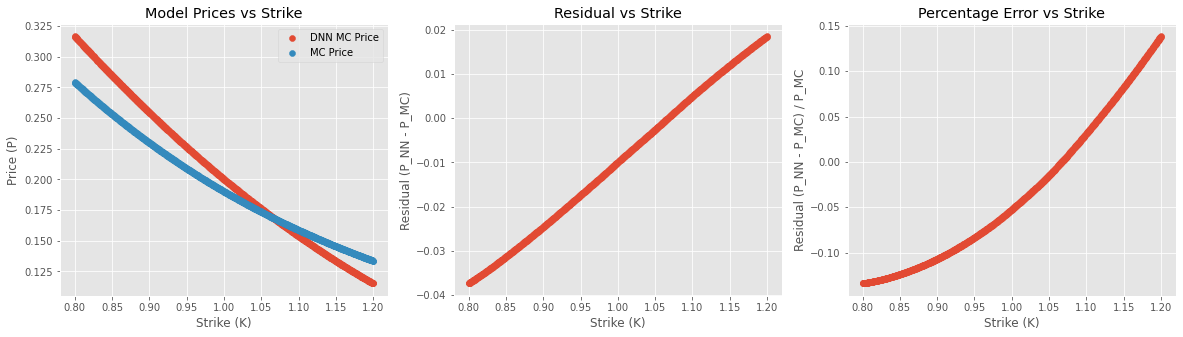

In [ ]:
test_losses = []
with torch.no_grad():
    Y0 = torch.ones((MC_SAMPLES, N + 1), dtype=torch.float)
    vols = torch.ones((MC_SAMPLES, N))
    temp = torch.ones((MC_SAMPLES, 1))
    for t in range(N):
        Y0[:, [t + 1]] = (
            Y0[:, [t]] + r * Y0[:, [t]] * dt + model(Y0[:, [t]].float()) * Ws[:, [t]]
        ).float()
        Y0[:, [t + 1]] = F.relu(Y0[:, [t + 1]]) + F.relu(-Y0[:, [t + 1]])
    pred = torch.mean(F.relu((Y0[:, [-1]] * torch.ones(1, M) - Ks)), 0)

fig, ax = plt.subplots(figsize=(20, 5), ncols=3)
ax[0].scatter(Ks, pred.detach().numpy(), label="DNN MC Price")
ax[0].scatter(Ks, Ps.detach().numpy(), label="MC Price")
ax[0].set_title("Model Prices vs Strike")
ax[0].set_xlabel("Strike (K)")
ax[0].set_ylabel("Price (P)")
ax[0].legend()
ax[1].scatter(Ks, (Ps - pred).detach().numpy())
ax[1].set_title("Residual vs Strike")
ax[1].set_xlabel("Strike (K)")
ax[1].set_ylabel("Residual (P_NN - P_MC)")
ax[2].scatter(Ks, ((Ps - pred) / Ps).detach().numpy())
ax[2].set_title("Percentage Error vs Strike")
ax[2].set_xlabel("Strike (K)")
ax[2].set_ylabel("Residual (P_NN - P_MC) / P_MC")

pred, Ps2 = pred.detach().numpy().reshape(-1), Ps.detach().numpy().reshape(-1)
for x in [
    np.mean(np.abs(pred - Ps2)),  # mae
    np.max(np.abs(pred - Ps2)),  # max-norm
    np.sqrt(np.mean((pred - Ps2) ** 2)),  # rmse
    np.mean(np.abs((pred - Ps2) / Ps2)),
]:  # mape
    print(f"{x:.6f}")